In [1]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
import shap
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score


In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='remove')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

meta = pd.read_csv('../metadata/metadata.csv', index_col=0)


(1172, 10396) (294, 10396) (530, 10396) (803, 10396)


In [3]:
meta.head(5)

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
cf1lenhr,What was the total length of interview - Hours,Continuous,paradata_and_weights,float64,0.000000,0.009892,0.003785,0.000000,0.007810,0.000000
cf1lenmin,What was the total length of interview - Minutes,Continuous,paradata_and_weights,float64,0.000000,0.000000,0.000000,0.001409,0.000000,0.000000
cf1fint,Constructed - Was father interviewed at baseline?,Binary,paradata_and_weights,object,0.021894,0.018859,0.016743,0.028699,0.000000,0.000000
cf1citsm,Constructed - Baseline city sample flag,Binary,paradata_and_weights,object,0.012485,0.023336,0.011364,0.000000,0.016590,0.004293
f1citywt,Father baseline city sample weight (20-cities ...,Continuous,paradata_and_weights,float64,0.000000,0.000000,0.000000,0.009234,0.002574,0.014284


In [4]:
targets = ['gpa','grit','materialHardship','eviction','layoff','jobTraining']

predictors = {target: list(meta[meta[target] != 0].index) for target in targets}

# Model

In [5]:
def run_model(train, target='gpa', classifier=False):
    X_train, y_train = prepare_data(train, target)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    ordered_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('target', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])

    numerical_features = cols_per_type(X_train, 'Continuous')
    categorical_features = cols_per_type(X_train, 'Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    ordinal_features = cols_per_type(X_train, 'Ordinal')
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        (ordered_transformer, ordinal_features),
        (ordered_transformer, binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(600, 1500),
            'regressor__learning_rate': space.Real(0.01, 0.06),
            'regressor__max_depth': space.Integer(5, 10),
            'regressor__min_child_weight': space.Integer(3, 5),
            'regressor__gamma': space.Real(0.1, 0.25),
            'regressor__subsample': space.Real(0.5, 0.8),
            'regressor__colsample_bytree': space.Real(0.5, 0.8),
            'regressor__colsample_bylevel': space.Real(0.5, 0.8),
        }
    
    if classifier:
        score = 'neg_brier_score'
        xgboost = XGBClassifier(n_jobs=-1, eval_metric='logloss', objective='binary:logistic')
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        xgboost = XGBRegressor(n_jobs=-1, eval_metric='rmse')
        score = 'neg_mean_squared_error'
    
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgboost)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=10,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    return model

In [6]:
def score_model(model, target, test, leaderboard, holdout, classifier=False):
    # Get CV score
    score = -model.best_score_
    print(f'Best CV score: {score:.4f}')
    
    # Get mean CV score
    mean_score = -model.cv_results_['mean_test_score'].mean()
    print(f'Mean CV score: {mean_score:.4f}')
    
    # Prepare test data
    X_test, y_test = prepare_data(test, target)

    if classifier:
        # Compute test scores
        y_pred = model.predict(X_test)
        brier = brier_score_loss(y_test, y_pred)
        f1 = f1_score(y_test, y_pred.round())
        
        # Print test scores
        print(f'Test Brier: {brier:.4f}')
        print(f'Test F1: {f1:.4f}')

        # # Compute leaderboard scores
        X_leaderboard, y_leaderboard = prepare_data(leaderboard, target)
        y_pred = model.predict(X_leaderboard)
        brier = brier_score_loss(y_leaderboard, y_pred)
        f1 = f1_score(y_leaderboard, y_pred.round())

        # # Print leaderboard scores
        print(f'Leaderboard Brier: {brier:.4f}')
        print(f'Leaderboard F1: {f1:.4f}')

        # # Compute holdout scores
        X_holdout, y_holdout = prepare_data(holdout, target)
        y_pred = model.predict(X_holdout)
        y_holdout = y_holdout.astype(int)
        brier = brier_score_loss(y_holdout, y_pred)
        print(f'Holdout Brier: {brier:.4f}')
        
        
    else:
        # Compute test scores
        mse = mean_squared_error(y_test, model.predict(X_test))
        rsquared = r2_score(y_test, model.predict(X_test))
        
        # Print test scores
        print(f'Test MSE: {mse:.4f}')
        print(f'Test R2: {rsquared:.4f}')

        # # Compute leaderboard scores
        X_leaderboard, y_leaderboard = prepare_data(leaderboard, target)
        mse = mean_squared_error(y_leaderboard, model.predict(X_leaderboard))
        rsquared = r2_score(y_leaderboard, model.predict(X_leaderboard))

        # Print leaderboard scores
        print(f'Leaderboard MSE: {mse:.4f}')
        print(f'Leaderboard R2: {rsquared:.4f}')

        # # Compute holdout scores
        X_holdout, y_holdout = prepare_data(holdout, target)
        # X_holdout_transformed = model.best_estimator_.named_steps['preprocessor'].transform(X_holdout)
        mse = mean_squared_error(y_holdout, model.predict(X_holdout))
        rsquared = r2_score(y_holdout, model.predict(X_holdout))

        # Print holdout scores
        print(f'Holdout MSE: {mse:.4f}')
        print(f'Holdout R2: {rsquared:.4f}')
        
def shap_show(model, alldata, target, n=5):
    X, y = prepare_data(alldata, target)
    model  = model.best_estimator_.fit(X, y)
    Xtransform = model.named_steps['preprocessor'].transform(X)
    exp = shap.TreeExplainer(model.named_steps['regressor'])
    transformer = model.named_steps['preprocessor']
    names = transformer.get_feature_names_out()
    featnames = [splitfeatname(name) for name in names]
    shap_values = exp.shap_values(Xtransform)
    # get top n features
    top_n_idx = np.argsort(np.abs(shap_values).mean(0))[-n:]
    top_n_feat = [featnames[i] for i in top_n_idx]
    # # get questions
    top_n_vars = [meta[meta.index.isin([feat])].varlab.values for feat in top_n_feat]
    # # reverse order
    top_n_vars = top_n_vars[::-1]
    shap.summary_plot(shap_values, Xtransform, max_display=n, feature_names=featnames)
    return dict(zip(map(tuple, top_n_vars), top_n_feat))


# GPA

In [7]:
gpa_model = run_model(train,target='gpa', classifier=False)

In [8]:
gpa_model.best_params_

OrderedDict([('regressor__colsample_bylevel', 0.7866433958929786),
             ('regressor__colsample_bytree', 0.7101864333864099),
             ('regressor__gamma', 0.23074778926948225),
             ('regressor__learning_rate', 0.030791054378972678),
             ('regressor__max_depth', 7),
             ('regressor__min_child_weight', 3),
             ('regressor__n_estimators', 600),
             ('regressor__subsample', 0.6112056462988114)])

In [9]:
score_model(gpa_model,'gpa',test,leaderboard,holdout,classifier=False)

Best CV score: 0.3945
Mean CV score: 0.4034
Test MSE: 0.4639
Test R2: 0.0271
Leaderboard MSE: 0.5541
Leaderboard R2: -0.4184
Holdout MSE: 0.5783
Holdout R2: -0.3699


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


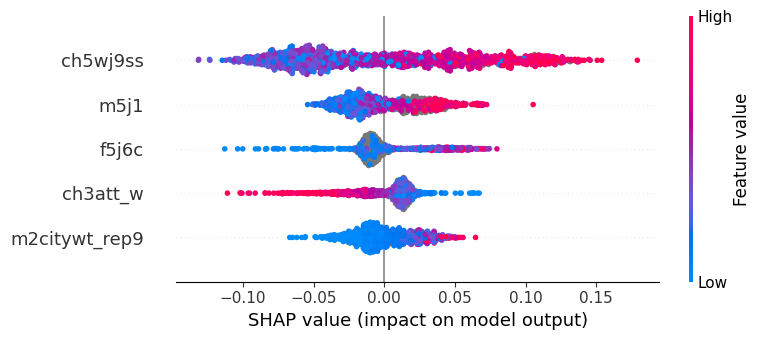

{('Woodcock Johnson Test 9 standard score',): 'm2citywt_rep9',
 ('J1. Total household income before taxes/deductions in past 12 months',): 'ch3att_w',
 ('J6C. Value of vehicle if sold',): 'f5j6c',
 ('attention-seeking',): 'm5j1',
 ('Mother one-year city replicate weight no. 9',): 'ch5wj9ss'}

In [10]:
shap_show(gpa_model, alldata, target='gpa')

# Material Hardship

In [11]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

In [12]:
model_materialHardship.best_params_

OrderedDict([('regressor__colsample_bylevel', 0.6230311876559942),
             ('regressor__colsample_bytree', 0.7183177229531976),
             ('regressor__gamma', 0.2399301998271751),
             ('regressor__learning_rate', 0.025789979674352433),
             ('regressor__max_depth', 8),
             ('regressor__min_child_weight', 4),
             ('regressor__n_estimators', 916),
             ('regressor__subsample', 0.7218512702571263)])

In [13]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Best CV score: 0.0192
Mean CV score: 0.0195
Test MSE: 0.0215
Test R2: 0.1487
Leaderboard MSE: 0.0318
Leaderboard R2: -0.1117
Holdout MSE: 0.0282
Holdout R2: -0.1551


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


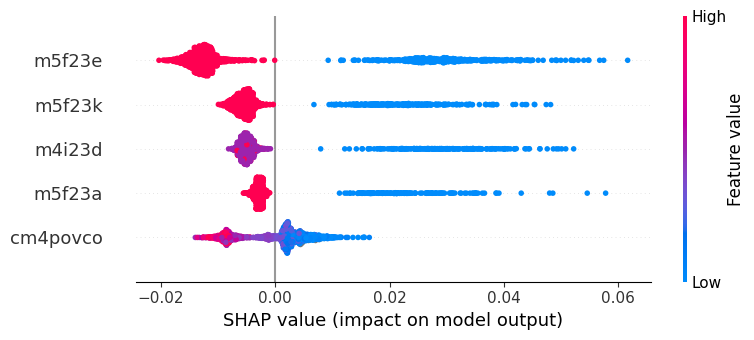

{('F23E. Did not pay full amount of gas/oil/electricity bill in past 12 months',): 'cm4povco',
 ("F23K. Telephone service disconnected because wasn't enough money in past 12 mont",): 'm5f23a',
 ("In past year, did not pay full amt rent/mortgage payments b/c wasn't enough",): 'm4i23d',
 ('F23A. Received free food or meals in past 12 months',): 'm5f23k',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'm5f23e'}

In [14]:
shap_show(model_materialHardship, alldata, target='materialHardship')


# Grit


In [15]:
model_grit = run_model(train,target='grit', classifier=False)

In [16]:
model_grit.best_params_

OrderedDict([('regressor__colsample_bylevel', 0.6230311876559942),
             ('regressor__colsample_bytree', 0.7183177229531976),
             ('regressor__gamma', 0.2399301998271751),
             ('regressor__learning_rate', 0.025789979674352433),
             ('regressor__max_depth', 8),
             ('regressor__min_child_weight', 4),
             ('regressor__n_estimators', 916),
             ('regressor__subsample', 0.7218512702571263)])

In [17]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Best CV score: 0.2482
Mean CV score: 0.2528
Test MSE: 0.2465
Test R2: -0.0670
Leaderboard MSE: 0.2912
Leaderboard R2: -0.3254
Holdout MSE: 0.2985
Holdout R2: -0.2494


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


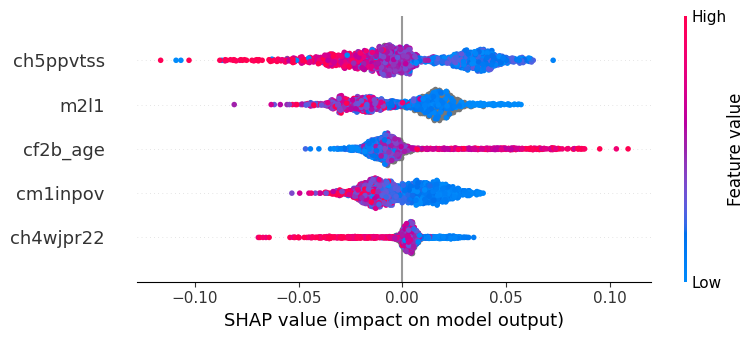

{('PPVT standard score',): 'ch4wjpr22',
 ('What was your total household income before taxes last year, all sources?',): 'cm1inpov',
 ("Constructed - Baby's age at time of father's one-year interview (months)",): 'cf2b_age',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'm2l1',
 ('Constructed - Child W-J - W-J percentile rank',): 'ch5ppvtss'}

In [18]:
shap_show(model_grit, alldata, target='grit')

In [19]:
meta[meta.index=='m5a8f01']

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
m5a8f01,A8F. Your relationship with the father at biol...,Ordered Categorical,romantic_relationships,category,0.0,0.0,0.026602,0.0,0.0,0.0


# Eviction

In [20]:
model_eviction = run_model(train,target='eviction', classifier=True)

In [21]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout, classifier=True)

Best CV score: 0.0559
Mean CV score: 0.0567
Test Brier: 0.0548
Test F1: 0.0000
Leaderboard Brier: 0.0660
Leaderboard F1: 0.0541
Holdout Brier: 0.0859


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


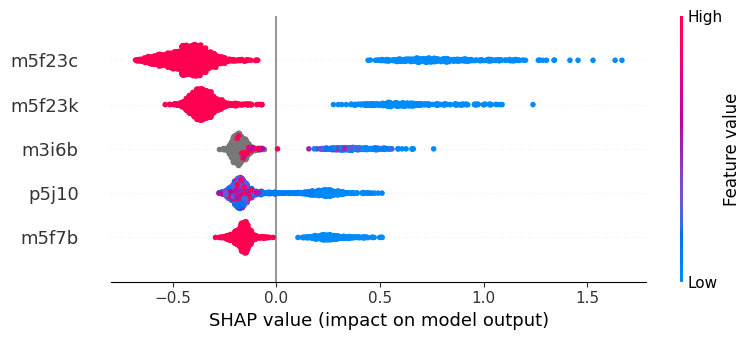

{('F23C. Did not pay full amount of rent/mortgage payments in past 12 months',): 'm5f7b',
 ("F23K. Telephone service disconnected because wasn't enough money in past 12 mont",): 'p5j10',
 ('How many days in past year did you go without phone service?',): 'm3i6b',
 ('J10. Amount of money spent eating out in last month',): 'm5f23k',
 ('F7B. Received help from a welfare office or welfare job placement in past 12 mon',): 'm5f23c'}

In [22]:
shap_show(model_eviction, alldata, target='eviction')

In [23]:
# top5 = ['m5f23k','p3m39','m5i3c']

# meta[meta.index.isin(top5)].varlab.values

# jobTraining

In [24]:
model_job = run_model(train,target='jobTraining', classifier=True)

In [25]:
score_model(model_job, 'jobTraining', test, leaderboard, holdout, classifier=True)

Best CV score: 0.1963
Mean CV score: 0.2079
Test Brier: 0.2397
Test F1: 0.2045
Leaderboard Brier: 0.3226
Leaderboard F1: 0.1576
Holdout Brier: 0.3275


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


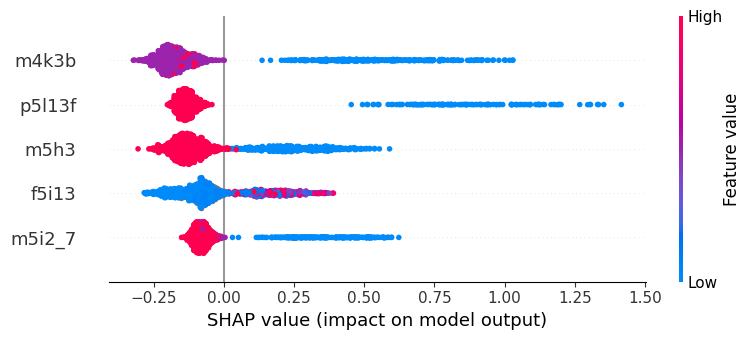

{('In the last 2 years, have you taken any classes to improve your job skills?',): 'm5i2_7',
 ('L13F. Gifted and talented program',): 'f5i13',
 ('H3. You had a religious experience that transformed your life since last intervi',): 'm5h3',
 ('i13. how much you earn in that job, before taxes',): 'p5l13f',
 ('I2_7. Attending vocational/technical/trade school',): 'm4k3b'}

In [26]:
shap_show(model_job, alldata, target='jobTraining')

In [27]:
top5 = ['m5i2_1','p5l13f','cm5hhinc']

meta[meta.index.isin(top5)].varlab.values

array(['I2_1. Attending regular high school',
       'L13F. Gifted and talented program',
       "Constructed - Mother's Household income (with imputed values)"],
      dtype=object)

# Layoff

In [28]:
model_layoff = run_model(train, target='layoff', classifier=True)

In [29]:
model_layoff.best_params_

OrderedDict([('regressor__colsample_bylevel', 0.501089092176423),
             ('regressor__colsample_bytree', 0.7453490058991254),
             ('regressor__gamma', 0.21119241165520408),
             ('regressor__learning_rate', 0.022727712893202245),
             ('regressor__max_depth', 8),
             ('regressor__min_child_weight', 4),
             ('regressor__n_estimators', 882),
             ('regressor__scale_pos_weight', 4),
             ('regressor__subsample', 0.7681514183157558)])

In [30]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout, classifier=True)

Best CV score: 0.1893
Mean CV score: 0.1977
Test Brier: 0.2093
Test F1: 0.0357
Leaderboard Brier: 0.2491
Leaderboard F1: 0.1081
Holdout Brier: 0.2366


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


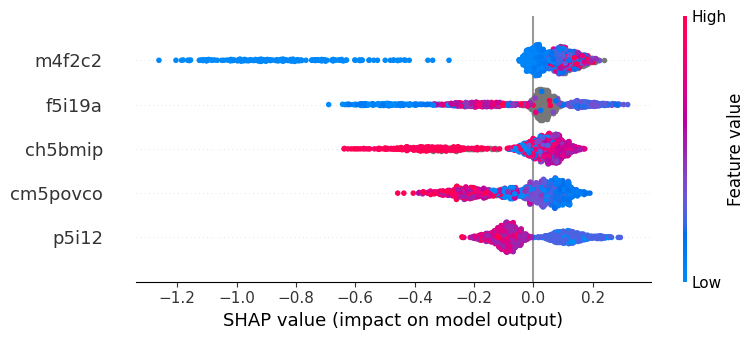

{("What is second person's age? (years)",): 'p5i12',
 ('I19A. Amount earned from all regular jobs in past 12 months',): 'cm5povco',
 ("Child's Body Mass Index percentile",): 'ch5bmip',
 ("Constructed - Mother's household income/poverty threshold at 9-year",): 'f5i19a',
 ('I12. Number of hours child sleeps on weeknights',): 'm4f2c2'}

In [31]:
shap_show(model_layoff, alldata, target='layoff')